In [1]:
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut,GridSearchCV,RandomizedSearchCV
import pandas as pd
import numpy as np
# def mape(y_true, y_pred): 
#     return np.mean(np.abs((np.expm1(y_true) - np.expm1(y_pred)) / np.expm1(y_true)+0.00001)) * 100


def mape(y_true, y_pred,sample_weight=None,multioutput='uniform_average'):
    y_type, y_true, y_pred, multioutput = _check_reg_targets(y_true, y_pred, multioutput)
    
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None
    return np.average(output_errors, weights=multioutput)

def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

In [2]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor as XGB
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR

In [3]:
from sklearn.metrics import make_scorer

In [4]:
dt = pd.read_csv('SF_good.csv').drop(['End_Lat','Start_Time','Wind_Chill(F)','Country','Timezone','Weather_Timestamp','End_Time','End_Lng','City','Street','County'],axis=1)

In [5]:
X = dt.drop(['ID','Description','Duration'],axis=1).iloc[:,:]
Y = dt.Duration.values
for C in X.columns:
    if len(X[C].unique())<29:
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        X[C] = le.fit_transform(X[C])

X=X.fillna(-1)

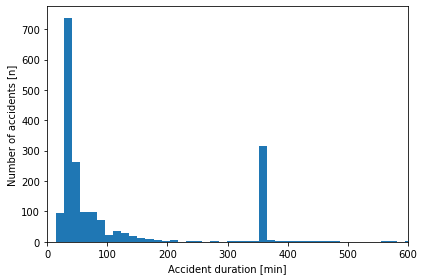

In [23]:
import matplotlib.pyplot as plt
plt.hist(Y,bins=200)
plt.xlim(0,600)
plt.xlabel('Accident duration [min]')
plt.ylabel('Number of accidents [n]')
plt.tight_layout()
plt.savefig('dist.pdf')

In [6]:
MAPE = make_scorer(mape,greater_is_better=False)

In [7]:
reg = RFR(n_estimators=100)
SCORE = cross_val_score(reg,X,np.log1p(Y),scoring=MAPE,cv=10).mean()
SCORE = np.round(np.abs(100.0*SCORE),2)

In [8]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.linear_model import LinearRegression as LR

In [9]:
DICT={}
DICT['RF'] = RFR
DICT['XGBoost'] = XGB
DICT['SVR'] = SVR
DICT['KNN'] = KNN
DICT['DT'] = DT
DICT['GBDT'] = GBR
DICT['LR'] = LR
# DICT['LightGBM'] = LG

In [10]:
MAPE='neg_mean_squared_error'

In [11]:
A=[]
for K in DICT:
    reg = DICT[K]()
    SCORE = cross_val_score(reg,X,np.log1p(Y),scoring=MAPE,cv=10).mean()
    SCORE += cross_val_score(reg,X,np.log1p(Y),scoring=MAPE,cv=10).mean()
    SCORE += cross_val_score(reg,X,np.log1p(Y),scoring=MAPE,cv=10).mean()
    SCORE=SCORE/3
    SCORE = np.round(np.abs(100.0*SCORE),2)
    print(K,',',SCORE)
    A.append([K,SCORE])

RF , 57.6
XGBoost , 63.41
SVR , 159.57
KNN , 87.13
DT , 94.49
GBDT , 58.4
LR , 102.36


In [72]:
xt = pd.DataFrame(A,columns=['MLi','MAPE [%]'])

In [73]:
xt = xt.sort_values('MAPE [%]')

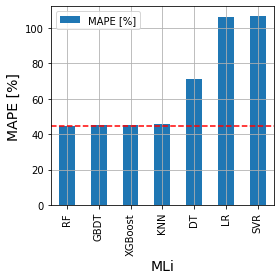

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4))
xt.plot.bar(x='MLi',y='MAPE [%]',ax=ax)

plt.xlabel('MLi',fontsize=14)
plt.ylabel('MAPE [%]',fontsize=14)
plt.axhline(y = xt['MAPE [%]'].min(), color = 'r', linestyle = '--',label='min MAPE')
plt.grid()
plt.tight_layout()
plt.savefig('baseline.pdf',format='pdf')

In [76]:
xt

,MLi,MAPE [%]
0,RF,44.58
5,GBDT,44.99
1,XGBoost,45.44
3,KNN,46.00
4,DT,71.29
6,LR,106.01
2,SVR,106.72
